In [3278]:
from minisom import MiniSom
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import random
from Square import *

data = pd.read_csv('SomXYZ.csv')
data = data.values
#moim zdaniem chyba nie potrzeba tutaj normalizować danych, ewentualnie po zmianach wartości x oraz y z jest zawsze -1 do 1
print(data.shape)

(10000, 3)


In [3279]:
print(data[:,2][3])

0.2588190451025207


In [3280]:
x_values = data[:,0]
y_values = data[:,1]
z_values = data[:,2]
min_x = min(x_values)
min_y = min(y_values)
max_x = max(x_values)
max_y = max(y_values)

In [3281]:
#nasz group_array nie ma sensu gdyz dzieli on listę np od recordu 0 do 50, a my poruszamy się w 3d więc musi dzielić np x: 0-5, y: 0-5
#mam na to napisaną metodę w c#
def group_array(data, x_jump, y_jump):
    x_segments_count = int((max_x - min_x) / x_jump)
    y_segments_count = int((max_y - min_y) / y_jump)
    segmented_points = []

    x = min_x
    y = min_y

    x_iterator = x_segments_count
    while(x_iterator >= 0):
       y_iterator = y_segments_count
       while(y_iterator >= 0):
          points = [point for point in data if point[0] >= x and point[0] < x + x_jump and point[1] >= y and point[1] < y+y_jump]
          x_pos = x_segments_count - x_iterator
          y_pos = y_segments_count - y_iterator
          segmented_points.append(Square(np.array(points), x_pos, y_pos))

          y += y_jump
          y_iterator = y_iterator -1
       x += x_jump
       y = min_y
       x_iterator = x_iterator - 1
    return(np.array(segmented_points))
    
squares = group_array(data,10,10)


In [3282]:
# squares[3].randomize_points(10) 
# bad_square = squares[3]

In [3283]:
random_square = random.randrange(0,len(squares))
squares[random_square].randomize_points(10) 
bad_square = squares[random_square]

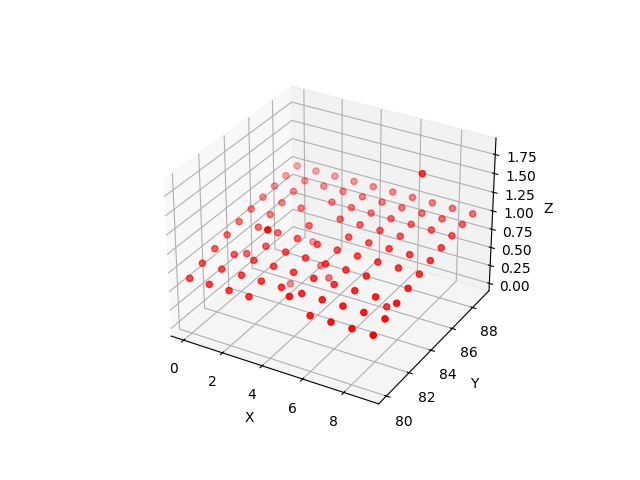

In [3284]:
%matplotlib ipympl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d') 

# Wykres punktowy 3D
ax.scatter(bad_square.points[:,0], bad_square.points[:,1], bad_square.points[:,2], c='r', marker='o')  # c - kolor,  marker - kształt punktoru

# Ustawianie etykiet osi
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Wyświetlenie wykresu
plt.show()

In [3285]:
som_3dim = squares[0].points_to_train.shape[0] #ilość wag w neuronie
points_to_train = np.array([x.points_to_train for x in squares]) #tworzenie listy składającej się z wektorów gotowych do treningu 
labels = np.array([int(x.bad_square) for x in squares])
print(points_to_train)


[[ 0.          0.          0.         ...  9.          9.
   0.70710678]
 [ 0.         10.          0.76604444 ...  9.         19.
   0.9961947 ]
 [ 0.         20.          0.98480775 ...  9.         29.
   0.57357644]
 ...
 [90.         70.         -0.17364818 ... 99.         79.
   0.57357644]
 [90.         80.          0.64278761 ... 99.         89.
   0.9961947 ]
 [90.         90.          1.         ... 99.         99.
   0.70710678]]


In [3286]:
dimentions = 5 * np.sqrt(points_to_train.shape[0])
grid_size = int(np.ceil(np.sqrt(dimentions)))

In [3287]:
def classify(som, data):
    """Classifies each sample in data in one of the classes definited
    using the method labels_map.
    Returns a list of the same length of data where the i-th element
    is the class assigned to data[i].
    """
    bad_pos = som.winner(bad_square.points_to_train)
    winmap = som.labels_map(points_to_train, labels)
    default_class = np.sum(list(winmap.values())).most_common()[0][0]
    result = []
    for d in data:
        win_position = som.winner(d)
        if win_position in winmap:
            if (len(winmap[win_position].most_common())) > 1:

                if winmap[win_position].most_common()[0][0] == 0:
                    result.append(winmap[win_position].most_common()[1][0])
                else:
                    result.append(winmap[win_position].most_common()[0][0]) 
                    
            else:
                result.append(winmap[win_position].most_common()[0][0])
        else:
            result.append(default_class)
    return result

In [3288]:
som = MiniSom(grid_size,grid_size, som_3dim, random_seed=42)
som.train(points_to_train, 1000)
#som.pca_weights_init(points_to_train)
# som.train_random(points_to_train, 500, verbose=False)


In [3289]:
classified = classify(som, points_to_train)
print(classification_report(labels, classified))
#print(np.array(classified).shape)


              precision    recall  f1-score   support

           0       0.99      1.00      0.99        99
           1       0.00      0.00      0.00         1

    accuracy                           0.99       100
   macro avg       0.49      0.50      0.50       100
weighted avg       0.98      0.99      0.99       100



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [3290]:
print(classified)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [3291]:
labelled = som.labels_map(points_to_train,labels)
default_class = np.sum(list(labelled.values())).most_common()[0][0]
print(default_class)
print(labelled[som.winner(bad_square.points_to_train)])


0
Counter({0: 3, 1: 1})


In [3292]:
print(len(labelled[som.winner(bad_square.points_to_train)]))

2


In [3293]:
print(len(np.sum(list(labelled.values()))))

2


In [3294]:
print(som.winner(bad_square.points_to_train))
print(bad_square.get_position())

(4, 0)
[0, 8]


In [3295]:
#przyjrzeć się metodzie som.labels_map()
#https://github.com/JustGlowing/minisom/blob/master/examples/Classification.ipynb
#przemyśleć czy całego generowania kwadratu nie przenieść do pliku od generowania daty
#nowa zaproponowana formuła danych: Dane: w jednej linii jeden kwadrat, Label, dla jednego kwadratu czy jest popsuty czy nie